## Context

In this notebook we will apply inferential statistic techniques to the KKbox data. In particular, we will investigate the following questions:

1. Are songs listened from 'My library' tab replay more than songs listened from other tabs?
2. What is the probability of a song to be replayed depending on the tab it was listened from? Probabilities will be expressed as confidence intervals. Are there statistically significant differences?
2. Are songs which belong to less genres replay more than songs which belong to more genres?
3. Is there a significant difference between males and females in the probability of replaying songs?
4. Do younger users replay songs more often than older users?


## Data

### train.csv
- msno: user id
- song_id: song id
- source_system_tab: the name of the tab where the event was triggered. System tabs are used to - categorize KKBOX mobile apps functions. For example, tab my library contains functions to -manipulate the local storage, and tab search contains functions relating to search.
- source_screen_name: name of the layout a user sees.
- source_type: an entry point a user first plays music on mobile apps. An entry point could be album, online-playlist, song .. etc.
- target: this is the target variable. target=1 means there are recurring listening event(s) triggered within a month after the user’s very first observable listening event, target=0 otherwise .

### songs.csv
The songs. Note that data is in unicode.
- song_id
- song_length: in ms
- genre_ids: genre category. Some songs have multiple genres and they are separated by |
- artist_name
- composer
- lyricist
- language

### members.csv
user information.
- msno
- city
- bd: age
- gender
- registered_via: registration method
- registration_init_time: format %Y%m%d
- expiration_date: format %Y%m%d

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
import math
import numpy as np
from IPython.display import clear_output
from scipy import stats

In [3]:
#Loading clean train document
train=pd.read_csv('data/train_clean.csv')
print(train.head())

                                           msno  \
0  FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=   
1  Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=   
2  Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=   
3  Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=   
4  FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=   

                                        song_id source_system_tab  \
0  BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=           explore   
1  bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=        my library   
2  JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=        my library   
3  2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=        my library   
4  3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=           explore   

    source_screen_name      source_type  target  
0              explore  online-playlist       1  
1  local playlist more   local-playlist       1  
2  local playlist more   local-playlist       1  
3  local playlist more   local-playlist       1  
4              explore  onli

In [4]:
#Transform variables into categorical
train.source_system_tab=train.source_system_tab.astype('category')
train.source_screen_name=train.source_screen_name.astype('category')
train.source_type=train.source_type.astype('category')

#### 1. Are songs listened from 'My library' tab replay more than songs listened from other tabs?

Based on the initial exploration of the data, it looks like songs listened from 'My library' tab have a higher probability to be listened again. 

- The null hypothesis: the replay probability from 'My library' tab and the rest of the tabs is the same. 
- The alternate hypothesis: the replay probability from 'My library' tab is higher than from the rest of the tabs. 

H0: pl=po versus Ha: pl≠po

Where p is the probability of a user to replay a song.

The statistic is the difference in replay probabilities between both samples.


In [4]:
#extract target variable for 'my library' tab entry
library=train[train.source_system_tab=='my library'].target.values

#extract target variable for other tab entries
others=train[train.source_system_tab!='my library'].target.values

In [5]:
#Function that generates many bootstrap replicates from a data set
def draw_bs_reps(data, func, reps=1):
    
    # Initialize array of replicates: bs_replicates
    bs_replicates=np.empty(reps)
    
    # Generate replicates
    for i in range(reps):
        clear_output(wait=True)
        bs_replicates[i]=func(np.random.choice(data, size=len(data)))
        
        print('Current progress: ',np.round(i/reps*100,2),"%")
    return bs_replicates

def bernoulli_p(data):
    return np.sum(data)/len(data)

In [6]:
#Generate bootstrap replicates of my library tab sample
bs_reps_library=draw_bs_reps(library,bernoulli_p,reps=1000)

#Generate bootstrap replicates of other tabs sample
bs_reps_others=draw_bs_reps(others,bernoulli_p,reps=1000)

Current progress:  99.9 %


In [7]:
#Compute differences in probabilities from the bs replicates
diff_probabilities=bs_reps_library-bs_reps_others

#Compute p_value
p_value=np.sum(diff_probabilities>=0)/len(diff_probabilities)
print('p-value: ',p_value)

p-value:  1.0


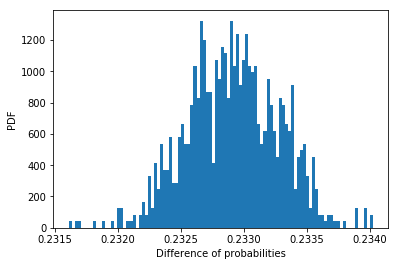

In [8]:
#Plot differences in probabilities distribution
plt.hist(diff_probabilities,bins=100,density=True)
plt.ylabel('PDF')
plt.xlabel('Difference of probabilities')
plt.show()

Since the p-value is really high, we reject the null hypothesis in favor of the alternative one. As seen in the plot above, the minimum difference observed in the replicates between 'My library' tab probability and the others is around 23.2%. 

We conclude that the probability of replaying a song when it is listened from 'My library' is higher than when it is listened from other tab.  

#### 2. What is the probability of a song to be replayed depending on the tab it was listened from?

In [9]:
def ci_bernouilli_p(data,confidence_level=0.95):
    """Compute p probability interval of confidence in a Bernoulli distribution"""
    #Compute data size
    n=len(data)
    
    #Compute probability
    p=np.sum(data)/n
    
    if n*p<10 or n*(1-p)<10:
        
        raise ValueError('The data is not large enough to compute confidence interval based on z-scores') 
    
    else: 
        #Compute standard error
        SE=np.sqrt(p*(1-p)/n)

        #Compute z-score
        z_score=stats.norm.ppf(1-(1-confidence_level)/2)

        #Compute margin of error
        ME=z_score*SE

        #Compute interval of confidence
        CI=[p-ME, p+ME]

        return p,ME,CI

In [12]:
#List unique values in source_system_tab column
tab_names=train.source_system_tab.unique()
print(tab_names,p,CI)

[explore, my library, search, discover, radio, listen with, notification, settings]
Categories (8, object): [explore, my library, search, discover, radio, listen with, notification, settings] 0.5909090909090909 [0.5703640504589651, 0.6114541313592168]


In [16]:
p_list=[]
ME_list=[]
for item in tab_names: 
    data= train[train.source_system_tab==item].target.values
    p,ME,CI=ci_bernouilli_p(data)
    p_list.append(p)
    ME_list.append(ME)

[0.42274824305588754, 0.6197156291041532, 0.42137168915482087, 0.4157419942442384, 0.22266251869628423, 0.32658695385891023, 0.37819889860706185, 0.5909090909090909] [0.00236688379751666, 0.0004957894509233533, 0.0012259167000877953, 0.0006544849148819712, 0.001181012063291431, 0.0019950424638417123, 0.012096247152141434, 0.020545040450125843]


[Text(0,0,'explore'),
 Text(0,0,'my library'),
 Text(0,0,'search'),
 Text(0,0,'discover'),
 Text(0,0,'radio'),
 Text(0,0,'listen with'),
 Text(0,0,'notification'),
 Text(0,0,'settings')]

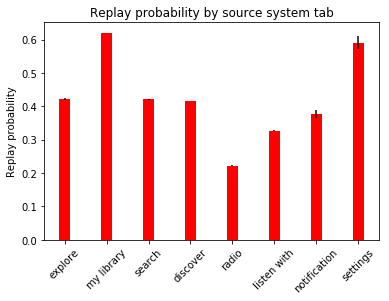

In [25]:
N=len(tab_names)
ind = np.arange(N)  # the x locations for the groups
width = 0.25       # the width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(ind, p_list, width, color='r', yerr=ME_list)
# add some text for labels, title and axes ticks
ax.set_ylabel('Replay probability')
ax.set_title('Replay probability by source system tab')
ax.set_xticks(ind)
ax.set_xticklabels(tab_names, rotation=45)

In [11]:
#Compute 95% confidence interval for probabilities of replay songs
#depending on the tab they were listened from
for item in tab_names:
    data= train[train.source_system_tab==item].target.values
    print('\033[1m'+ item +' tab:'+ '\033[0m')
    p,ME,CI=ci_bernouilli_p(data)
    print('The margin of error is ',ME)
    print('The probability confidence interval is: ', CI)

explore tab:
The margin of error is  0.00236688379751666
The probability confidence interval is:  [0.4203813592583709, 0.4251151268534042]
my library tab:
The margin of error is  0.0004957894509233533
The probability confidence interval is:  [0.6192198396532299, 0.6202114185550766]
search tab:
The margin of error is  0.0012259167000877953
The probability confidence interval is:  [0.42014577245473306, 0.4225976058549087]
discover tab:
The margin of error is  0.0006544849148819712
The probability confidence interval is:  [0.41508750932935645, 0.41639647915912037]
radio tab:
The margin of error is  0.001181012063291431
The probability confidence interval is:  [0.2214815066329928, 0.22384353075957567]
listen with tab:
The margin of error is  0.0019950424638417123
The probability confidence interval is:  [0.32459191139506854, 0.3285819963227519]
notification tab:
The margin of error is  0.012096247152141434
The probability confidence interval is:  [0.36610265145492044, 0.39029514575920327]


After computing confidence intervals of the probability of replaying a song based on the tab the song was listened from, we can conclude is not only 'my library tab' but also 'settings' that have a higher probability that the rest of the tabs. The lower limit of the confidence interval for 'my library tab' (0.61) and for 'settings' tab (0.57) is higher that the upper limit of the rest of the tabs.

Finally, 'radio' tab is clearly the worse tab in terms of probabilities. The higher limit of the confidence interval is lower than any of the lower limits of the rest of the tabs confidence intervals. 

#### 3. Are songs which belong to less genres replay more than songs which belong to more genres?

In the initial exploratory analysis we tried to check if there was a relationship between the number of genres a song belongs to and the probability of it to be played again. It looks like the more genres a song belongs to, the less probability will have to be replay. Something that could be a bit counterintuitive. 

Our null hypothesis: there is no correlation between the number of genres a song belongs to and the replay probability

H0: ρ=0 Ha: ρ≠0

Our test statistic is the pearson correlation ρ between both variables.

In [12]:
#Display unique songs and number of users listening to them
train_song_info=train.groupby('song_id')['msno'].count().to_frame()

In [13]:
#Add total times each song was played again in replayed_songs column
train_song_info['replayed_songs']=train.groupby('song_id')['target'].sum()

In [14]:
#Select only songs with a sample equal or higher than 10 users
train_song_info_selection=train_song_info[train_song_info.msno>=10]

In [15]:
#Compute probalility of replay
train_song_info_selection['p']=train_song_info_selection.apply(lambda row: (row['replayed_songs']/row['msno']), axis=1)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [16]:
train_song_info_selection.head()

,msno,replayed_songs,p
song_id,,,
++7GdTgp8zbQLYOki7hVPEOHpu+KLZClsGrGiEuL2uI=,54,22,0.407407
++CfKs1t1wU1t0q0UxCdRqGoDpToqgMPmYytklaqo9o=,41,18,0.439024
++QYBUGIUXrSsYfBPDW4PN5V6wnlJzLYCwP+FS9gMnY=,13,3,0.230769
++QfzyM/LiFaCuvkDFK/wJe13ZEMgTgAaVCcolo7nnY=,3395,2168,0.638586
++VJq2+JeJByPWmj7Gf58ptVkIje+t9xeptpK3BARx4=,13,7,0.538462


In [17]:
#Import songs clean csv
songs=pd.read_csv('data/songs_clean.csv')
print(songs.head())

                                        song_id  song_length_min genre_ids  \
0  CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=         4.127333   ['465']   
1  o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=         3.288800   ['444']   
2  DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=         3.863017   ['465']   
3  dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=         4.559233   ['465']   
4  W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=         2.338817   ['726']   

        artist_name                                  composer  \
0  張信哲 (Jeff Chang)                                    ['董貞']   
1         Blackpink  ['Teddy', 'Future Bounce', 'Bekuh Boom']   
2      Super Junior                                       NaN   
3             S.H.E                                   ['湯小康']   
4              貴族精選                           ['Traditional']   

          lyricist  language  genre_count  
0          ['何啟弘']         3          1.0  
1        ['Teddy']        31          1.0  
2       

In [18]:
#Adding probability to be replayed to songs table: songs_with_prob
#Only songs with 10 or more users samples are considered
songs_with_prob=pd.merge(train_song_info_selection,songs,right_on='song_id',left_index=True)
songs_with_prob.head()

,msno,replayed_songs,p,song_id,song_length_min,genre_ids,artist_name,composer,lyricist,language,genre_count
40331,54,22,0.407407,++7GdTgp8zbQLYOki7hVPEOHpu+KLZClsGrGiEuL2uI=,4.451250,['458'],袁詠琳 (Cindy Yen),['Cindy袁詠琳'],"['賴雅妍', '黃俊郎']",3,1.0
208844,41,18,0.439024,++CfKs1t1wU1t0q0UxCdRqGoDpToqgMPmYytklaqo9o=,3.742900,['465'],Juniel,"['Two Face ', '이상호 (Lee Sang Ho)']",['한성호 (Han Sung Ho)'],31,1.0
197771,13,3,0.230769,++QYBUGIUXrSsYfBPDW4PN5V6wnlJzLYCwP+FS9gMnY=,8.304217,['873'],Tasha Cobbs,['William Reagan'],NaN,52,1.0
1660525,3395,2168,0.638586,++QfzyM/LiFaCuvkDFK/wJe13ZEMgTgAaVCcolo7nnY=,3.583600,['444'],Twice,['Black Eyed Win 1'],NaN,31,1.0
63292,13,7,0.538462,++VJq2+JeJByPWmj7Gf58ptVkIje+t9xeptpK3BARx4=,4.842133,['437'],Infinite,['Ryuichi Kawamura'],NaN,17,1.0


In [19]:
#Check Na values
songs_with_prob.isna().sum()

msno                   0
replayed_songs         0
p                      0
song_id                0
song_length_min        0
genre_ids            874
artist_name            0
composer           22796
lyricist           37562
language               0
genre_count          874
dtype: int64

In [20]:
#Select only rows with known values for genre_count
songs_with_prob_selection=songs_with_prob[songs_with_prob.genre_count.notnull()]

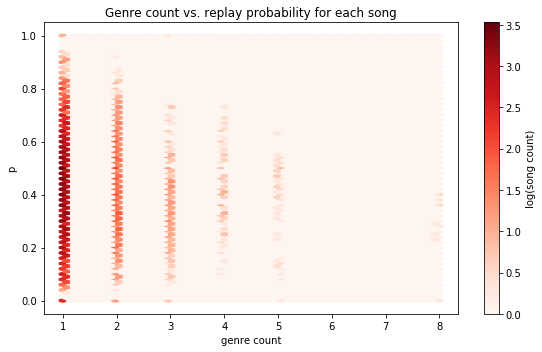

In [21]:
#Plot replay probability versus number of genres a song belongs to
fig, ax = plt.subplots(figsize=(8,5))
hb = ax.hexbin(x=songs_with_prob_selection.genre_count,y=songs_with_prob_selection.p, gridsize=(50,50),cmap=plt.cm.Reds, bins='log')

#ax.scatter(x, y,alpha=0.2)
#Add labels
cb=fig.colorbar(hb, ax=ax, label='log(song count)')
ax.set_ylabel('p')
ax.set_xlabel('genre count')
ax.set_title ('Genre count vs. replay probability for each song')

#Show plot
fig.tight_layout()

In [22]:
def pearson_r(x, y):
    """Compute Pearson correlation coefficient between two arrays."""
    # Compute correlation matrix: corr_mat
    corr_mat=np.corrcoef(x,y)

    # Return entry [0,1]
    return corr_mat[0,1]

In [23]:
#Compute observed correlation between genre_count and replay probability
r_obs=pearson_r(songs_with_prob_selection.p,songs_with_prob_selection.genre_count)
print('The observed Pearson correlation is: ', r_obs)

The observed Pearson correlation is:  -0.020805338914803843


In [24]:
#Initiate permutation replicates: perm_replicates
perm_replicates=np.empty(10000)

#Generate replicates
for i in range(10000):
    #Permute genre_count: genre_count_permuted
    genre_count_permuted=np.random.permutation(songs_with_prob_selection.genre_count)
    
    #Compute Pearson correlation
    perm_replicates[i]=pearson_r(genre_count_permuted,songs_with_prob_selection.p)

#Compute p-value: p
p_value=np.sum(perm_replicates>=r_obs)/len(perm_replicates)
print("p-value: ",p_value)

p-value:  1.0


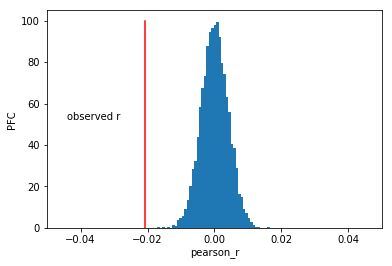

In [25]:
#Plot permutation replicates
_= plt.hist(perm_replicates, bins=50, density=True)

#Plot observed person correlation
_= plt.plot(np.array([r_obs,r_obs]),np.array([0,100]), color='red')

#Add labels
_= plt.xlim((-0.05, 0.05))
_= plt.ylabel('PFC')
_= plt.xlabel('pearson_r')
_= plt.figtext(.17, .5, "observed r")

#Display plot
plt.show()

Since the p_value is really high, we reject the null hypothesis in favor of the alternative one. There is negative correlation between the number of genres a song belong to and the probability of that song to be replay. 

Nonetheless the observed correlation is very small and therefore is not useful for practical purposes.

#### 4. Are there women more likely to replay songs than men?

The null hypothesis: the probability of songs to be replayed is the same for women and men.

H0: μw=μm
Ha: μw≠μm

The test statistic we will use is the difference in means. 

In [26]:
members=pd.read_csv('data/members_clean.csv')
print(members.head())
print(members.info())

                                           msno  city  bd gender  \
0  XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=     1 NaN    NaN   
1  UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=     1 NaN    NaN   
2  D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=     1 NaN    NaN   
3  mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=     1 NaN    NaN   
4  q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=     1 NaN    NaN   

   registered_via registration_init_time expiration_date  
0               7             2011-08-20      2017-09-20  
1               7             2015-06-28      2017-06-22  
2               4             2016-04-11      2017-07-12  
3               9             2015-09-06      2015-09-07  
4               4             2017-01-26      2017-06-13  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34402 entries, 0 to 34401
Data columns (total 7 columns):
msno                      34402 non-null object
city                      34402 non-null int64
bd                        14439 no

In [27]:
#Compute probability of replaying songs for each user
users_prob=train.groupby('msno').target.mean().to_frame()

#Compute total unique songs listened by user
users_prob['total_songs']=train.groupby('msno').msno.count()
users_prob.head()

,target,total_songs
msno,,
++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,0.497453,589
++AH7m/EQ4iKe6wSlfO/xXAJx50p+fCeTyF90GoE9Pg=,0.640909,220
++e+jsxuQ8UEnmW40od9Rq3rW7+wAum4wooXyZTKJpk=,0.703704,108
++xWL5Pbi2CpG4uUugigQahauM0J/sBIRloTNPBybIU=,0.062500,16
+/SKX44s4ryWQzYzuV7ZKMXqIKQMN1cPz3M8CJ8CFKU=,0.369369,222


In [28]:
#Join users probability and member attributes 
#Only users who have listened 10 or more songs
df=pd.merge(users_prob[users_prob.total_songs>=10],members,right_on='msno',left_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26510 entries, 20065 to 2612
Data columns (total 9 columns):
target                    26510 non-null float64
total_songs               26510 non-null int64
msno                      26510 non-null object
city                      26510 non-null int64
bd                        12768 non-null float64
gender                    12783 non-null object
registered_via            26510 non-null int64
registration_init_time    26510 non-null object
expiration_date           26510 non-null object
dtypes: float64(2), int64(3), object(4)
memory usage: 2.0+ MB


In [29]:
#Segment members where gender is not null
members_gender_selection=df[df.gender.notnull()]

In [30]:
members_gender_selection.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12783 entries, 20065 to 2612
Data columns (total 9 columns):
target                    12783 non-null float64
total_songs               12783 non-null int64
msno                      12783 non-null object
city                      12783 non-null int64
bd                        12378 non-null float64
gender                    12783 non-null object
registered_via            12783 non-null int64
registration_init_time    12783 non-null object
expiration_date           12783 non-null object
dtypes: float64(2), int64(3), object(4)
memory usage: 998.7+ KB


In [31]:
members_gender_selection.head()

,target,total_songs,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
20065,0.497453,589,++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,13,39.0,male,9,2006-02-18,2017-10-21
28671,0.640909,220,++AH7m/EQ4iKe6wSlfO/xXAJx50p+fCeTyF90GoE9Pg=,9,21.0,female,4,2015-11-20,2017-01-01
4579,0.703704,108,++e+jsxuQ8UEnmW40od9Rq3rW7+wAum4wooXyZTKJpk=,14,31.0,male,7,2014-08-01,2017-05-05
13108,0.062500,16,++xWL5Pbi2CpG4uUugigQahauM0J/sBIRloTNPBybIU=,17,18.0,male,3,2012-12-09,2017-01-29
32101,0.479798,198,+/UwoUi5+rNj/F6RO6gMrMhOy0oTzs90MWKVNZs4+Wg=,15,28.0,male,3,2015-09-05,2017-09-13


In [32]:
#Extract women rows
w=members_gender_selection[members_gender_selection.gender=='female']

#Compute w mean probability of replaying songs
pw=w.target.mean()
print('The observed probability for women is: ',pw)

The observed probability for women is:  0.4766182799898453


In [33]:
#Extract men rows
m=members_gender_selection[members_gender_selection.gender=='male']

#Compute w mean probability of replaying songs
pm=m.target.mean()
print('The observed probability for men is: ',pm)

The observed probability for men is:  0.4893707030983739


In [34]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n=len(data)

    # x-data for the ECDF: x
    x=np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

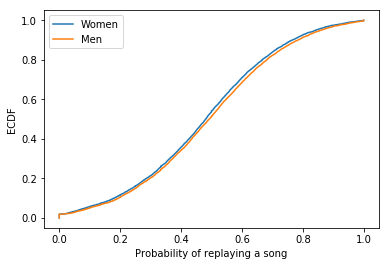

In [35]:
#Compute ecdf values for women probabilities
x_w,y_w=ecdf(w.target.values)

#Compute ecdf values for men probabilites
x_m,y_m=ecdf(m.target.values)

#Plot ecdfs for both distributions
plt.plot(x_w,y_w)
plt.plot(x_m,y_m)

#Add labels
plt.ylabel('ECDF')
plt.xlabel('Probability of replaying a song')
plt.legend(('Women','Men'))

#Display plot
plt.show()

From the ECDF plot it looks like both distributions are very similar.

In [36]:
def permutation_sample(data_1,data_2):
    "Generate permutation of one sample"
    #Concatenate data_1 and data_2: data
    data= np.concatenate((data_1,data_2))
    
    # Permute the concatenated array: perm
    perm=np.random.permutation(data)
    
    # Split the permuted array into two: perm_1, perm_2
    perm_1=perm[:len(data_1)]
    perm_2=perm[len(data_1):]
    return perm_1,perm_2

def draw_perm_reps(data_1,data_2,func,size=1):
    "Generate permutation replicates"
    # Initialize array of replicates: perm_replicates
    perm_replicates=np.empty(size)
    
    for i in range(size):
        #Generate permutation sample
        perm_sample_1, perm_sample_2= permutation_sample(data_1,data_1)
    
        # Compute the test statistic
        perm_replicates[i] = func(perm_sample_1,perm_sample_2)
        
    return perm_replicates

def diff_of_means(data_1,data_2):
    "Compute difference of means"
    return np.mean(data_1)-np.mean(data_2)

In [37]:
#Compute empirical difference of means
empirical_diff_means=diff_of_means(w.target.values,m.target.values)
print('Empirical difference of means (female-male): ',empirical_diff_means)

#Draw 10,000 permutation replicates: perm_replicates
perm_replicates=draw_perm_reps(w.target.values,m.target.values,diff_of_means,size=10000)

#Compute p-value
p_value=np.sum(perm_replicates>=empirical_diff_means)/len(perm_replicates)
print('p-value: ',p_value)

Empirical difference of means (female-male):  -0.012752423108527422
p-value:  0.9994


There is a 99.98% probability of observing a test statistic equally or more extreme than the one you observed, given that the null hypothesis is true.

At a confidence level of 95%, provided that this is a two tailed test, the null hypothesis would be rejected. The p-value is higher than 97.5%.

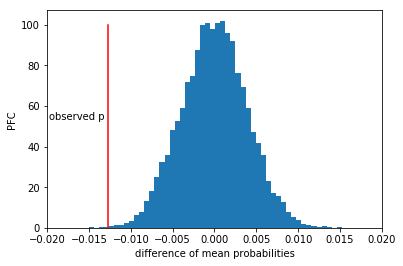

In [38]:
#Plot permutation replicates
_= plt.hist(perm_replicates, bins=50, density=True)

#Plot observed person correlation
_= plt.plot(np.array([empirical_diff_means,empirical_diff_means]),np.array([0,100]), color='red')

#Add labels
_= plt.xlim((-0.02, 0.02))
_= plt.ylabel('PFC')
_= plt.xlabel('difference of mean probabilities')
_= plt.figtext(.13, .5, "observed p")

#Display plot
plt.show()

#### 5. Do younger users replay songs more often than older users?

In [39]:
#Segment members where age is not null
members_bd_selection=df[df.bd.notnull()]

Text(0.5,0,'age')

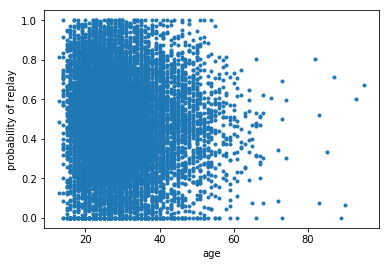

In [40]:
#Scatter plot: replay probability versus user's age
plt.plot(members_bd_selection.bd,members_bd_selection.target, marker='.',linestyle='none')
plt.ylabel('probability of replay')
plt.xlabel('age')

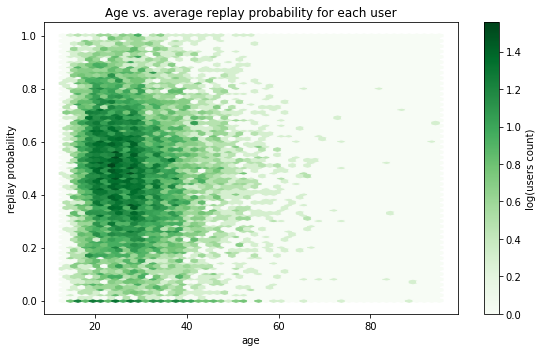

In [41]:
#Hexbin plot: replay probability versus user's age
fig, ax = plt.subplots(figsize=(8,5))
hb = ax.hexbin(x=members_bd_selection.bd,y=members_bd_selection.target, gridsize=(50,50),cmap=plt.cm.Greens, bins='log')

#Add labels
cb=fig.colorbar(hb, ax=ax, label='log(users count)')
ax.set_ylabel('replay probability')
ax.set_xlabel('age')
ax.set_title ('Age vs. average replay probability for each user')

#Show plot
fig.tight_layout()

From the plot there is no clear correlation between the variables. We will do a hypothesis test to check.

Null hypothesis: there is no correlation between the age and the replay probability.

H0: ρ=0 Ha: ρ≠0

The test statistic is the Pearson correlation between both variables. 

In [42]:
#Compute observer Pearson correlation
r_obs=pearson_r(members_bd_selection.bd,members_bd_selection.target)
print('The observed Pearson correlation is: ', r_obs)

The observed Pearson correlation is:  -0.09029854435131413


In [43]:
#Initiate permutation replicates: perm_replicates
perm_replicates=np.empty(10000)

#Generate replicates
for i in range(10000):
    #Permute age: age_permuted
    age_permuted=np.random.permutation(members_bd_selection.bd)
    
    #Compute Pearson correlation
    perm_replicates[i]=pearson_r(age_permuted,members_bd_selection.target)

#Compute p-value: p
p_value=np.sum(perm_replicates>=r_obs)/len(perm_replicates)
print("p-value: ",p_value)

p-value:  1.0


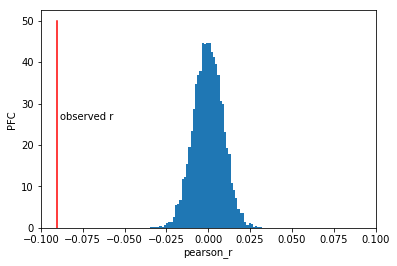

In [44]:
#Plot permutation replicates
_= plt.hist(perm_replicates, bins=50, density=True)

#Plot observed person correlation
_= plt.plot(np.array([r_obs,r_obs]),np.array([0,50]), color='red')

#Add labels
_= plt.xlim((-0.1, 0.1))
_= plt.ylabel('PFC')
_= plt.xlabel('pearson_r')
_= plt.figtext(.17, .5, "observed r")

#Display plot
plt.show()

Since the p_value is really high, we reject the null hypothesis in favor of the alternative one. 

There is  a week negative correlation between the users' age and the mean probability of a user to replay songs. Overall the probability decreases as users get older. 